<a href="https://www.kaggle.com/code/sitbayevalibek/breast-cancer-predict-portfolio?scriptVersionId=131107833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-dataset/data.csv


<div style="background-color: orange; border: 3px dashed red; font-size: 20px;">
    <p>Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.</p>
</div>


# Breast cancer detection

# Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('/kaggle/input/breast-cancer-dataset/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

<p style="background-color: orange; font-size: 20px;"> The 'diagnosis' column indicates whether the tumor is cancerous (M - malignant) or non-cancerous (B - benign).</p>

In [5]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

<p style="background-color: orange; font-size: 20px;">We change these values to 0 and 1. M->1, B->0</p>

# LabelEncoder

In [6]:
labelencoder = LabelEncoder()
df['diagnosis'] = labelencoder.fit_transform(df['diagnosis'].values)
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

<p style="background-color: orange; font-size: 20px;">We drop the ID column</p>

In [7]:
df.drop(columns=['id'], inplace=True)

In [8]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<p style="background-color: orange; font-size: 20px;">We check if there are NaN values</p>

In [9]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [10]:
df.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

<p style="background-color: orange; font-size: 20px;">
Correlation</p>

In [11]:
corr_matrix = df.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,0.012838,0.567134,0.008303,0.556141,0.548236,0.067016,0.292999,0.253730,0.408042,0.006522,0.077972,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,0.311631,0.679090,0.097317,0.674172,0.735864,0.222600,0.206000,0.194204,0.376169,0.104321,0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,0.023389,0.236702,0.302418,0.293464,0.071401,0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,0.261477,0.691765,0.086761,0.693135,0.744983,0.202694,0.250744,0.228082,0.407217,0.081629,0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,0.283110,0.732562,0.066280,0.726628,0.800086,0.166777,0.212583,0.207660,0.372320,0.072497,0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave_points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


# Correlation

<p style="background-color: orange; font-size: 20px;">df correlation with column 'diagnosis'</p>

In [12]:
df.corrwith(df['diagnosis']).abs().sort_values(ascending=False)

diagnosis                  1.000000
concave_points_worst       0.793566
perimeter_worst            0.782914
concave_points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave_points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0

<p style="background-color: orange; font-size: 20px;">We remove columns with low correlation.</p>

In [13]:
cols = [
'fractal_dimension_se',
'smoothness_se',
'fractal_dimension_mean',
'texture_se',
'symmetry_se']

high_corr = df.drop(cols, axis=1)

In [14]:
high_corr

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Preparing for Machine Learning

<p style="background-color: orange; font-size: 20px;">Preparing for Machine Learning</p>

In [15]:
X = high_corr.drop('diagnosis', axis=1).values
y = high_corr['diagnosis']

<p style="background-color: orange; font-size: 20px;">StandardScaler</p>

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

<p style="background-color: orange; font-size: 20px;">Train/test split</p>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

# Modelling

<p style="background-color: orange; font-size: 20px;">Modelling</p>

<p style="background-color: orange; font-size: 20px;">KNeighborsClassifier</p>

In [18]:
knn = KNeighborsClassifier(n_neighbors=5) # k-value 5

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
y_predict = knn.predict(X_test)

<p style="background-color: orange; font-size: 20px;">Evaluation</p>

# Jaccard index

<p style="background-color: orange; font-size: 20px;">Jaccard index</p>

In [20]:
jaccard_score(y_test, y_predict)

0.8958333333333334

# Confusion matrix

<p style="background-color: orange; font-size: 20px;">Confusion matrix</p>

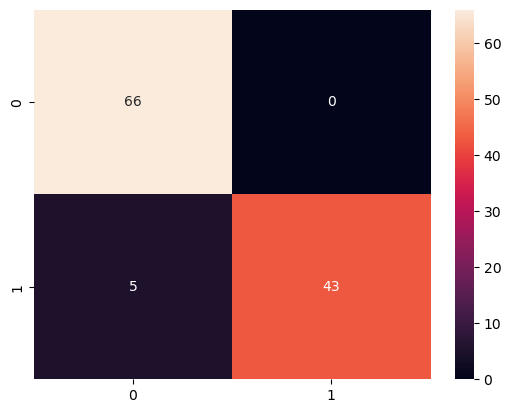

In [21]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

# Precision, Recall, F1, Accuracy, ROC_AUC

<p style="background-color: orange; font-size: 20px;">k-NN Confusion Matrix</p>

<p style="background-color: orange; font-size: 20px;">precision_score, recall_score, f1_score, accuracy_score, roc_auc_score</p>

In [22]:
precision_knn = precision_score(y_test, y_predict)
recall_knn = recall_score(y_test, y_predict)
f1_knn = f1_score(y_test, y_predict)
accuracy_knn = accuracy_score(y_test, y_predict)
roc_auc_knn = roc_auc_score(y_test, y_predict)
print(f"{precision_knn=:.3f}\n{recall_knn=:.3f}\n{f1_knn=:.3f}\n{accuracy_knn=:.3f}\n{roc_auc_knn=:.3f}")

precision_knn=1.000
recall_knn=0.896
f1_knn=0.945
accuracy_knn=0.956
roc_auc_knn=0.948


# Cross-Validation

<p style="background-color: orange; font-size: 20px;">We check using cross-validation</p>

In [23]:
predict = cross_val_predict(estimator = knn, X = X, y = y, cv = 5)

<p style="background-color: red; font-size: 20px;">precision_score, recall_score, f1_score, accuracy_score, roc_auc_score</p>

In [24]:
precision_cv = precision_score(y, predict)
recall_cv = recall_score(y, predict)
f1_cv = f1_score(y, predict)
accuracy_cv = accuracy_score(y, predict)
roc_auc_cv = roc_auc_score(y, predict)
print(f"{precision_cv=:.3f}\n{recall_cv=:.3f}\n{f1_cv=:.3f}\n{accuracy_cv=:.3f}\n{roc_auc_cv=:.3f}")

precision_cv=0.981
recall_cv=0.953
f1_cv=0.967
accuracy_cv=0.975
roc_auc_cv=0.971


<p style="background-color: lightgreen; font-size: 20px;">With the help of cross-validation, the model worked more accurately</p>

<p style="background-color: orange; font-size: 20px;">AdaBoost classifier</p>

In [25]:

abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
#Predict the response for test dataset
y_predictabc = model.predict(X_test)

<p style="background-color: orange; font-size: 20px;">Random Forest</p>

In [26]:
rand_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'sqrt',
                                  min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rand_clf.fit(X_train, y_train)
y_predictrnd = rand_clf.predict(X_test)

<p style="background-color: orange; font-size: 20px;">Histogram gradient boosting</p>

In [27]:
hgb_clf = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
hgb_clf.fit(X_train,y_train)
y_predicthgb = hgb_clf.predict(X_test)

# Model Evaluation

<p style="background-color: orange; font-size: 20px;">AdaBoost classifier evaluation</p>

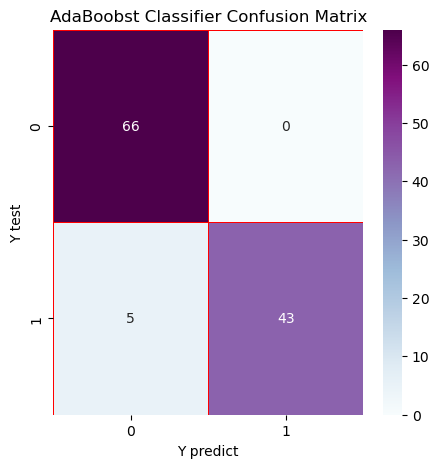

In [28]:
# The confusion matrix
abc_cm = confusion_matrix(y_test, y_predictabc)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(abc_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('AdaBoobst Classifier Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [29]:
precision_abc = precision_score(y_test, y_predictabc)
recall_abc = recall_score(y_test, y_predictabc)
f1_abc = f1_score(y_test, y_predictabc)
accuracy_abc = accuracy_score(y_test, y_predictabc)
roc_auc_abc = roc_auc_score(y_test, y_predictabc)
print(f"{precision_abc=:.3f}\n{recall_abc=:.3f}\n{f1_abc=:.3f}\n{accuracy_abc=:.3f}\n{roc_auc_abc=:.3f}")

precision_abc=1.000
recall_abc=0.896
f1_abc=0.945
accuracy_abc=0.956
roc_auc_abc=0.948


<p style="background-color: orange; font-size: 20px;">Random forest evaluation</p>

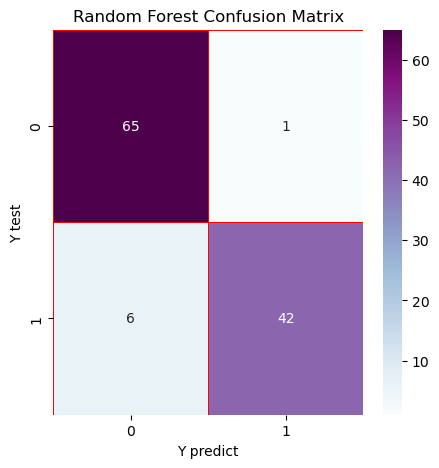

In [30]:
# The confusion matrix
rnd_cm = confusion_matrix(y_test, y_predictrnd)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rnd_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [31]:
precision_rnd = precision_score(y_test, y_predictrnd)
recall_rnd = recall_score(y_test, y_predictrnd)
f1_rnd = f1_score(y_test, y_predictrnd)
accuracy_rnd = accuracy_score(y_test, y_predictrnd)
roc_auc_rnd = roc_auc_score(y_test, y_predictrnd)
print(f"{precision_rnd=:.3f}\n{recall_rnd=:.3f}\n{f1_rnd=:.3f}\n{accuracy_rnd=:.3f}\n{roc_auc_rnd=:.3f}")

precision_rnd=0.977
recall_rnd=0.875
f1_rnd=0.923
accuracy_rnd=0.939
roc_auc_rnd=0.930


<p style="background-color: orange; font-size: 20px;">Histogram gradient tree evaluation</p>

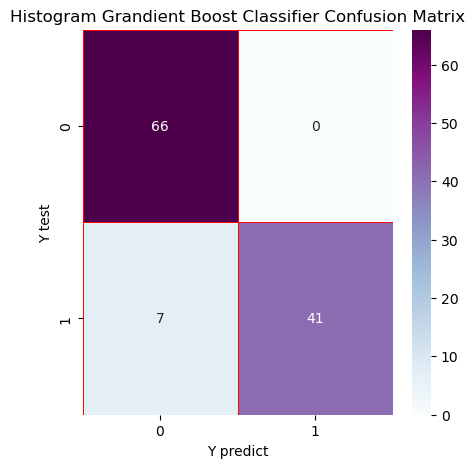

In [32]:
# The confusion matrix
hgb_cm = confusion_matrix(y_test, y_predicthgb)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(hgb_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
plt.title('Histogram Grandient Boost Classifier Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [33]:
precision_hgb = precision_score(y_test, y_predicthgb)
recall_hgb = recall_score(y_test, y_predicthgb)
f1_hgb = f1_score(y_test, y_predicthgb)
accuracy_hgb = accuracy_score(y_test, y_predicthgb)
roc_auc_hgb = roc_auc_score(y_test, y_predicthgb)
print(f"{precision_hgb=:.3f}\n{recall_hgb=:.3f}\n{f1_hgb=:.3f}\n{accuracy_hgb=:.3f}\n{roc_auc_hgb=:.3f}")

precision_hgb=1.000
recall_hgb=0.854
f1_hgb=0.921
accuracy_hgb=0.939
roc_auc_hgb=0.927


# Results

<p style="background-color: lightgreen; font-size: 30px; border: 3px dashed red;">Comparison.</p>

In [34]:

data = {'Metric': ['precision', 'recall', 'f1', 'accuracy', 'roc_auc'],
        'HGB Model': ['{:.3f}'.format(precision_hgb), '{:.3f}'.format(recall_hgb), '{:.3f}'.format(f1_hgb), '{:.3f}'.format(accuracy_hgb), '{:.3f}'.format(roc_auc_hgb)],
        'RND Model': ['{:.3f}'.format(precision_rnd), '{:.3f}'.format(recall_rnd), '{:.3f}'.format(f1_rnd), '{:.3f}'.format(accuracy_rnd), '{:.3f}'.format(roc_auc_rnd)],
        'ABC Model': ['{:.3f}'.format(precision_abc), '{:.3f}'.format(recall_abc), '{:.3f}'.format(f1_abc), '{:.3f}'.format(accuracy_abc), '{:.3f}'.format(roc_auc_abc)],
        'kNN Model': ['{:.3f}'.format(precision_knn), '{:.3f}'.format(recall_knn), '{:.3f}'.format(f1_knn), '{:.3f}'.format(accuracy_knn), '{:.3f}'.format(roc_auc_knn)],
        'CV Model': ['{:.3f}'.format(precision_cv), '{:.3f}'.format(recall_cv), '{:.3f}'.format(f1_cv), '{:.3f}'.format(accuracy_cv), '{:.3f}'.format(roc_auc_cv)]
       }

results = pd.DataFrame(data)
results


,Metric,HGB Model,RND Model,ABC Model,kNN Model,CV Model
0,precision,1.000,0.977,1.000,1.000,0.981
1,recall,0.854,0.875,0.896,0.896,0.953
2,f1,0.921,0.923,0.945,0.945,0.967
3,accuracy,0.939,0.939,0.956,0.956,0.975
4,roc_auc,0.927,0.930,0.948,0.948,0.971
